# Dolan Creek: Obtain and Process Gridded PRISM

Obtain the PRISM 4km precipitation grid for all days from 1/1981 to the present. Only the 4 km precipitation grid is free.

Notebook Organization

https://automating-gis-processes.github.io/2016/Lesson7-read-raster.html


## Parameters and Imports

In [1]:
# our imports
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
# this tells Jupyter to embed matplotlib plots in the notebook
%matplotlib notebook
import matplotlib
from IPython.display import display, HTML
import shapely as sp
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from descartes import PolygonPatch
import gdal
import gdalconst
from shapely.geometry import Point
from shapely.geometry import Polygon
import urllib.parse as urlp
import urllib.request as urlr
import urllib.error as urle

### Parameters and File Locations

In [2]:
PRISM_ENDPT = r'http://services.nacse.org/prism/data/public/4km/'
ELEMENT_OPTIONS = [ 'ppt', 'tmin', 'tmax', 'tmean', 'tdmean', 'vpdmin', 'vpdmax' ]

In [3]:
TEMP_DIR = r'C:\Temp\PRISM_Temp'
FILEOUT_DIR = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Re' \
              r'charge\Data\Weather\PRISM_Daily'

In [4]:
SNO_DATA = -9999.0

Some parameters

In [5]:
START_DT = dt.datetime( 1981, 1, 1 )
PRISM_DT_FMT = "%Y%m%d"
ZIP_EXT = '.zip'
SPLITTER = '_'
ZIP_SWITCH = r'/vsizip/'

Two boundary files are required. These are used to extract all of the PRISM grid cell centers within the big boundary. Consequently, the big boundary needs to encompass the watershed with a 4 km buffer. One of these files needs to be in NAD83 degrees to use with the PRISM values from the website and the other should be in UTM 14 N, meters to plot with reprojected grid.

In [6]:
CLIP_BND = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Re' \
           r'charge\GIS\Shapefiles\BigBound_NAD83.shp'
PLT_CLIP = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Rec' \
           r'harge\GIS\Shapefiles\UTM14N\BigBoundary.shp'

The AOI is normally the watershed. Texas counties are also loaded to use as a reference.

In [7]:
TX_COUNTY_SHP = r'\\augustine.space.swri.edu\jdrive\Groundwater\23209-WGCD Num' \
                r'Model\GIS\Shapefiles_final\Counties.shp'
AOI_SHP = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Re' \
          r'charge\GIS\Shapefiles\UTM14N\AOI.shp'

Load the boundaries and save their crs information

In [8]:
ClipNAD83 = gpd.read_file( CLIP_BND )
crs_NAD83 = ClipNAD83.crs
print("%s" % crs_NAD83)

{'init': 'epsg:4269'}


In [9]:
ClipWGS84 = gpd.read_file( PLT_CLIP )
crs_WGS84 = ClipWGS84.crs
print("%s" % crs_WGS84 )

{'init': 'epsg:32614'}


In [10]:
gpd_AOI = gpd.read_file( AOI_SHP )

In [11]:
gpd_TXCO = gpd.read_file( TX_COUNTY_SHP )

In [12]:
# convert the texas counties to UTM, WGS84
gpd_TXCOUTM = gpd_TXCO.to_crs( crs_WGS84 )

## Process PRISM Rasters

Next load the GDAL driver that is needed for reading the file

In [13]:
gdal.GetDriverByName('EHdr').Register()

203

### Generic Functions for Processing

In [14]:
def makeGridAndCentroids( InBIL, InCRS ):
    """Take the input raster in ArcGIS BIL format and create GeoDataFrames representing
    the raster grid in polygon format and point format where each point is the polygon
    centroid or the center of the raster cell. Assign the CRS and return both 
    GeoDataFrames.
    
    Arguments:
        InBIL (string): fully qualified path to the raster file to use to extract the grid
        InCRS (dict): projection/coordinate system dictionary
        
    Return:
        Tuple T - [0](GeoDataFrame): polygon grid with index1 and geometry. Return empty geodataframe for error
                - [1](GeoDataFrame): centroid points with index1 and geometry. Return empty geodataframe for error
    """
    # open our raster file
    img = gdal.Open( InBIL, gdalconst.GA_ReadOnly )
    # get a reference to the band/data
    oBand1 = img.GetRasterBand(1)
    # get the geogransform information to make the 'grid'
    GTT = img.GetGeoTransform()
    OrigX = GTT[0]
    OrigY = GTT[3]
    PixW = GTT[1]
    PixH = GTT[5]
    # get the number of rows and columns
    NumCol = img.RasterXSize
    NumRow = img.RasterYSize
    # now make our shapes and put them in a list to represent the grid
    GridList = list()
    PointList = list()
    for iI in range(NumRow):
        for jJ in range(NumCol):
            X1 = OrigX + (jJ * PixW)
            Y1 = OrigY + (iI * PixH)
            X2 = OrigX + ( (jJ + 1) * PixW )
            Y2 = OrigY + (iI * PixH)
            X3 = OrigX + ( (jJ + 1) * PixW )
            Y3 = OrigY + ( (iI + 1) * PixH )
            X4 = OrigX + (jJ * PixW)
            Y4 = OrigY + ( (iI + 1) * PixH )
            Pt1 = Point( X1, Y1 )
            Pt2 = Point( X2, Y2 )
            Pt3 = Point( X3, Y3 )
            Pt4 = Point( X4, Y4 )
            PolyList = [ ( X1, Y1 ), ( X2, Y2 ), ( X3, Y3 ), ( X4, Y4 ) ]
            OurPoly = Polygon( PolyList )
            GridList.append( OurPoly )
            PointList.append( OurPoly.centroid )
        # end of inner for
    # end of outer for
    TotalCells = NumRow * NumCol
    # make two geodataframes, one for each geometry type
    DataDict = { "Index1" : range(1, TotalCells + 1, 1),
               }
    PtsDF = pd.DataFrame( data=DataDict )
    PolysDF = pd.DataFrame( data=DataDict )
    # now do the geodataframes
    Points_gdf = gpd.GeoDataFrame( PtsDF, geometry=PointList )
    Points_gdf.crs = InCRS
    Polys_gdf = gpd.GeoDataFrame( PolysDF, geometry=GridList )
    Polys_gdf.crs = InCRS
    # close the dataset before returning
    img = None
    # now return
    return (Polys_gdf, Points_gdf)

In [15]:
def loadRasterData( InBIL, ColName, BandNum ):
    """Load raster data from an ArcGIS BIL file
    
    Arguments:
        InBIL (string): fully qualified path to the raster file to use to extract the grid
        ColName (string): column name for the return DataFrame for the data
        BandNum (int): the band number to read from - starts at 1
        
    Returns:
        DataDF (DataFrame): dataframe with two columns, Index1 which is index starting with 1 and Data
    """
    # parameters
    EmptyDF = pd.DataFrame( data={} )
    # open our raster file
    img = gdal.Open( InBIL, gdalconst.GA_ReadOnly )
    # check that opened something
    if img is None:
        return EmptyDF
    # get the number of rows, columns, and bands
    NumCol = img.RasterXSize
    NumRow = img.RasterYSize
    NumBands = img.RasterCount
    # adjust our BandNum if is out of range
    if BandNum > NumBands:
        BandNum = 1
    # get a reference to the band/data
    oBand1 = img.GetRasterBand( BandNum )
    # get our no data value
    NO_DATA = oBand1.GetNoDataValue()
    # get the total number of cells
    TotalCells = NumRow * NumCol
    # read the data
    FData = oBand1.ReadAsArray()
    # flatten it out
    FDataV = FData.flatten()
    # create the data dictionary
    DataDict = { "Index1" : range(1, TotalCells + 1, 1),
                 ColName : FDataV,
               }
    DataDF = pd.DataFrame( data=DataDict )
    # now replace the no data values with NaNs
    DataDF.replace( NO_DATA, np.nan, inplace=True )
    # set the img reference
    img = None
    # return
    return DataDF

In [16]:
def extractDT( CompName ):
    """Extract the datestring from a zip archive name. While doing this check for a zip archive
    
    Arguments:
        CompName (str): directory item name that checking for if zip archive
        
    Returns:
        CurDT (dt.datetime): the extacted date. Return none if could not extract.
        
    """
    # globals
    global PRISM_DT_FMT, ZIP_EXT, SPLITTER
    # local parameters
    DINDEX = 4
    # start of function
    if not ZIP_EXT in CompName:
        # then is probably not a zip file
        print("No %s in %s!!!" % (ZIP_EXT, CompName))
        return None
    # if made it here then split
    NameComponents = CompName.split( SPLITTER )
    NumComp = len( NameComponents )
    if NumComp <= DINDEX:
        # then there are not enough items
        print("Issue parsing %s; has %d components" % (CompName, NumComp))
        return None
    # now try to parse the date
    try:
        CurDT = dt.datetime.strptime( NameComponents[DINDEX], PRISM_DT_FMT )
    except:
        print("Issue parsing time from %s of %s" % (NameComponents[DINDEX], CompName))
        return None
    # if made it here then return the good
    return CurDT

def checkForZip( CompName ):
    """Check that seems to be a zip archive
    
    Arguments:
        CompName (str): directory item name that checking for if zip archive
        
    Returns:
        RetStatus (bool): true = is zip
        
    """
    # globals
    global PRISM_DT_FMT, ZIP_EXT, SPLITTER
    # local parameters
    # start of function
    if not ZIP_EXT in CompName:
        # then is probably not a zip file
        print("No %s in %s!!!" % (ZIP_EXT, CompName))
        return False
    else:
        return True

In [17]:
def findBILinZip( ZipA ):
    """Find the name of the .bil raster in a zip archive.
    
    Arguments:
        ZipA (string): fully qualifed path name to zip archive
        
    Returns:
        BilFile (string): the name of the .bil file
        
    """
    # imports
    import zipfile
    # local parameters
    BadFile = ""
    CheckBil = "_bil.bil"
    Check2 = ".xml"
    # check that our file exists
    if not os.path.exists( ZipA ):
        return BadFile
    # if made it here then try to access
    try:
        zFile = zipfile.ZipFile( ZipA )
    except:
        print("Issue with zip file %s!!!!" % ZipA)
        return BadFile
    # now if made it here let's look for the bil fle.
    AllNames = zFile.namelist()
    BilFile = BadFile
    FoundIt = False
    for tName in AllNames:
        if CheckBil in tName:
            # then need to do our second check
            if Check2 in tName:
                continue
            else:
                BilFile = tName
                FoundIt = True
                break
            # end of inner if
        # end of outer if
    # end of for
    if not FoundIt:
        return BadFile
    # now return
    return BilFile

### Create PRISM Grid for AOI

Get a single PRISM grid from the web access site and process this to identify the values that we want in our region of interest.

Set the end time and use this to get a recent grid.

In [18]:
today_now = dt.datetime.now()
END_DT = dt.datetime( today_now.year, today_now.month, today_now.day ) - dt.timedelta( days=1 )
END_DT

datetime.datetime(2019, 6, 20, 0, 0)

Get a raster grid from the PRISM web access site to make our local area.

In [19]:
DateStr = END_DT.strftime( PRISM_DT_FMT )
tElem = ELEMENT_OPTIONS[0]
# get our output directory
OutDir = os.path.normpath( TEMP_DIR )
# make the full end point
tSubStr = "%s/" % tElem
Url1 = urlp.urljoin( PRISM_ENDPT, tSubStr )
Url2 = urlp.urljoin( Url1, DateStr )
# get our output file string
OutZFile = "PRISM_tfile_stable_4kmD1_bil.zip"
OutFP = os.path.normpath( os.path.join( OutDir, OutZFile ) )
# now are ready to make our request; use 4 retry
attempts = 0
while attempts < 4:
    try:
        response = urlr.urlopen( Url2, timeout=10 )
        content = response.read()
        fID = open( OutFP, 'w+b' )
        fID.write( content )
        fID.close()
        break
    except urle.URLError as err:
        attempts += 1
        print("Working on %s, Error: %s" % (OutZFile, type(err)))
    except:
        attempts += 1
        print("Unknown error working on %s, maybe timeout error!!!" % OutZFile)
# end of inner while
# extract the file name from the zip
BFile = findBILinZip( OutFP )
BIL_FILE = "%s%s\%s" % (ZIP_SWITCH, OutFP, BFile)

In [20]:
RetTuple = makeGridAndCentroids( BIL_FILE, crs_NAD83 )
PolyGrid = RetTuple[0]
CentGrid = RetTuple[1]
NumPoly = len( PolyGrid )
NumCent = len( CentGrid )
if (NumPoly <= 0) or (NumCent <= 0):
    print("Error reading in PRISM grid from the BIL file !!!!")
else:
    print("Read in PRISM grid from %s" % OutFP )

Read in PRISM grid from C:\Temp\PRISM_Temp\PRISM_tfile_stable_4kmD1_bil.zip


Now we want to clip our full PRISM grid to get only our area of interest.

In [21]:
ExGridNAD83 = gpd.overlay( ClipNAD83, PolyGrid, how='intersection' )

Also extract our points. This does not use overlay but need to query for if are within.

In [22]:
AOI_Mask = CentGrid.within( ClipNAD83.loc[0, 'geometry'] )
ExPntsNAD83 = CentGrid.loc[AOI_Mask].copy()

In [23]:
len(ExPntsNAD83), len(ExGridNAD83), len(PolyGrid)

(210, 240, 872505)

Now we want to convert to the GAM coordinate system and plot for checking

In [24]:
ExGridWGS84 = ExGridNAD83.to_crs( crs_WGS84 )
ExPntsWGS84 = ExPntsNAD83.to_crs( crs_WGS84 )

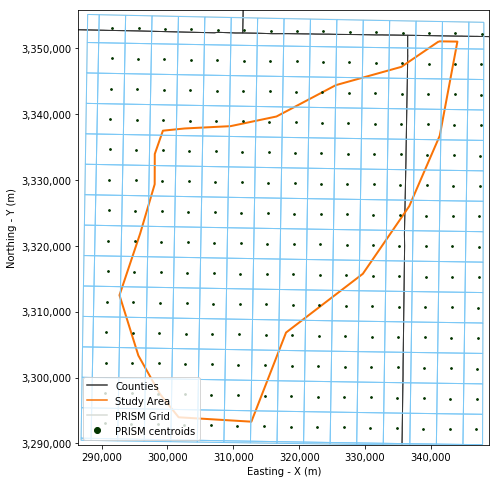

In [25]:
Fig1 = plt.figure()
Fig1.set_size_inches(12.0, 8.0)
ax11 = Fig1.add_subplot(111)
gpd_TXCOUTM.plot( ax=ax11, facecolor='none', edgecolor='xkcd:dark grey' )
ClipWGS84.plot( ax=ax11, facecolor='none', edgecolor='xkcd:light grey' )
gpd_AOI.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="AOI" )
ExGridWGS84.plot( ax=ax11, facecolor='none', edgecolor='xkcd:lightblue' )
ExPntsWGS84.plot( ax=ax11, marker='o', color='xkcd:dark green', markersize=3 )
txc = Line2D( [0], [0], linestyle='-', color='xkcd:dark grey' )
aoi = Line2D( [0], [0], linestyle='-', color='xkcd:light grey' )
ao = Line2D( [0], [0], linestyle='-', color='xkcd:orange' )
pgrid = Line2D( [0], [0], linestyle='-', color='xkcd:light grey' )
pcent = Line2D( [], [], linestyle='None', marker='o', color='xkcd:dark green')
ax11.legend( (txc, ao, pgrid, pcent), ('Counties', 'Study Area', 'PRISM Grid', 'PRISM centroids'),
             loc='lower left')
ax11.set_xlim( ( 286500, 348800 ) )
ax11.set_ylim( ( 3289800, 3355800 ) )
ax11.set_xlabel('Easting - X (m)')
ax11.set_ylabel('Northing - Y (m)')
ax11.yaxis.set_major_formatter( matplotlib.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( matplotlib.ticker.StrMethodFormatter( "{x:,.0f}" ) )

Now calculate the area for each grid cell that extracted in square meters.

In [26]:
ExGridWGS84["New_Area_m2"] = ExGridWGS84.geometry.area

In [27]:
ExGridWGS84.drop(columns='Id', inplace=True )

In [28]:
display( HTML( ExGridWGS84.head().to_html() ) )

,Shape_Leng,Shape_Area,Index1,geometry,New_Area_m2
0,237897.378163,3.529765e+09,662337,"POLYGON ((325716.8044914886 3354322.927228396,...",1.655575e+07
1,237897.378163,3.529765e+09,662340,"POLYGON ((337737.5590962378 3354100.067182836,...",1.640379e+07
2,237897.378163,3.529765e+09,662338,"POLYGON ((329723.7576626952 3354247.167613508,...",1.650508e+07
3,237897.378163,3.529765e+09,662342,"POLYGON ((348027.23851624 3353919.825521393, 3...",9.354797e+06
4,237897.378163,3.529765e+09,662336,"POLYGON ((321709.8149563536 3354400.159944925,...",1.660644e+07


In [29]:
ExPntsWGS84A = ExPntsWGS84.merge( ExGridWGS84[['Index1', 'New_Area_m2']], left_on='Index1', 
                                  right_on='Index1' )

In [30]:
display( HTML( ExPntsWGS84A.head().to_html() ) )

,Index1,geometry,New_Area_m2
0,662328,POINT (291619.2247031514 3353093.044753992),1.701255e+07
1,662329,POINT (295627.4652986222 3353017.290083501),1.696173e+07
2,662330,POINT (299635.6524244148 3352943.008720022),1.691092e+07
3,662331,POINT (303643.7871283953 3352870.200525675),1.686013e+07
4,662332,POINT (307651.870458468 3352798.865365324),1.680936e+07


Get our unique points list and unique polygons list

In [31]:
UniquePts = sorted( ExPntsWGS84A['Index1'].unique() )
UniquePolys = sorted( ExGridWGS84['Index1'].unique() )

In [32]:
len( ExPntsWGS84A ), len(UniquePts)

(210, 210)

In [33]:
len( ExGridWGS84 ), len(UniquePolys)

(240, 240)

Now output

In [ ]:
#OutFiler = "AOI_PRISM_Pts.shp"
#OutFilePath = os.path.normpath( os.path.join( FILEOUT_DIR, OutFiler ) )
#ExPntsWGS84A.to_file( OutFilePath, driver='ESRI Shapefile' )

In [ ]:
#OutFiler = "AOI_PRISM_Poly.shp"
#OutFilePath = os.path.normpath( os.path.join( FILEOUT_DIR, OutFiler ) )
#ExGridWGS84.to_file( OutFilePath, driver='ESRI Shapefile' )

## Acquire and Process PRISM Rasters

PRISM datasets are available for ftp-style download for each day and each parameter. If do not have the data, then go through and download all datasets as zip files. Many times will already have some of this record because what is downloaded is for CONUS. In those cases only need to change the start date below to update the downloaded record.

Change the start time if necessary.

In [36]:
TStartDT = START_DT
#TStartDT = dt.datetime( 1981, 1, 1, 0, 0, 0 )
TStartDT

datetime.datetime(1981, 1, 1, 0, 0)

In [37]:
ExDateRange = pd.date_range( start=TStartDT, end=END_DT, freq='D' )
TotTimes = len( ExDateRange )
TotTimes

14050

Now go through the data period and each of the data types and get each day for each type.

In [ ]:
AnnualPtsDict = dict()
AnnualPolyDict = dict()
for tElem in ELEMENT_OPTIONS:
    CPtsDict = dict()
    PolysDict = dict()
    # now set our initial dictionary structure
    for tPt in UniquePts:
        CPtsDict[tPt] = [SNO_DATA for x in range(TotTimes)]
    for tPoly in UniquePolys:
        PolysDict[tPoly] = [SNO_DATA for x in range(TotTimes)]
    OutCnt = 0
    fCnt = 0
    for dtTS in ExDateRange:
        # get our DateStr
        DateStr = dtTS.strftime( PRISM_DT_FMT )
        # get our output directory
        OutDir = os.path.normpath( TEMP_DIR )
        # make the full end point
        tSubStr = "%s/" % tElem
        Url1 = urlp.urljoin( PRISM_ENDPT, tSubStr )
        Url2 = urlp.urljoin( Url1, DateStr )
        # get our output file string
        OutZFile = "PRISM_tfile_stable_4kmD1_bil.zip"
        OutFP = os.path.normpath( os.path.join( OutDir, OutZFile ) )
        # now are ready to make our request; use 4 retry
        SuccessRead = False
        attempts = 0
        while attempts < 5:
            try:
                response = urlr.urlopen( Url2, timeout=8 )
                content = response.read()
                fID = open( OutFP, 'w+b' )
                fID.write( content )
                fID.close()
                SuccessRead = True
                break
            except urle.URLError as err:
                attempts += 1
                print("Working on %s, %s; Error: %s" % (tElem, DateStr, type(err)))
            except:
                attempts += 1
                print("Unknown error working on %s, %s; maybe timeout error!!!" % (tElem, DateStr))
        # end of inner while
        OutCnt += 1
        if OutCnt >= 3650:
            print("In %s At %s" % (tElem, dtTS.strftime( "%m/%d/%Y" ) ) )
            OutCnt = 0
        # process our temporary file if successful
        if SuccessRead:
            # extract the file name from the zip
            BFile = findBILinZip( OutFP )
            BIL_FILE = "%s%s\%s" % (ZIP_SWITCH, OutFP, BFile)
            # get the data
            DataDF = loadRasterData( BIL_FILE, tElem, 1 )
            if len(DataDF) <= 0:
                print("Error processing time %s for %s; not updated!!!!" % (DateStr, tElem))
                fCnt += 1
                continue
            # now process the data
            for tPt in UniquePts:
                CPtsDict[tPt][fCnt] = float( DataDF[DataDF['Index1'] == tPt][tElem] )
            # end of for
            for tPoly in UniquePolys:
                PolysDict[tPoly][fCnt] = float( DataDF[DataDF['Index1'] == tPoly][tElem] )
            # end of for
        else:
            print("Error downloading %s for %s. Not updated!!!" % (DateStr, tElem))
        # update the counter
        fCnt += 1
        # end of if
    # end of time for
    # now need to create our dataframe and output
    PtsDF = pd.DataFrame( index=ExDateRange, data=CPtsDict )
    PolyDF = pd.DataFrame( index=ExDateRange, data=PolysDict )
    # replace any no datas with NaNs
    PtsDF.replace( to_replace=SNO_DATA, value=np.nan, inplace=True )
    PolyDF.replace( to_replace=SNO_DATA, value=np.nan, inplace=True )
    # next resample to annual
    if tElem == ELEMENT_OPTIONS[0]:
        AnnPtsDF = PtsDF.resample( 'AS', closed='left', label='left' ).sum()
        AnnPolyDF = PolyDF.resample( 'AS', closed='left', label='left' ).sum()
    elif tElem == ELEMENT_OPTIONS[1]:
        AnnPtsDF = PtsDF.resample( 'AS', closed='left', label='left' ).min()
        AnnPolyDF = PolyDF.resample( 'AS', closed='left', label='left' ).min()
    elif tElem == ELEMENT_OPTIONS[2]:
        AnnPtsDF = PtsDF.resample( 'AS', closed='left', label='left' ).max()
        AnnPolyDF = PolyDF.resample( 'AS', closed='left', label='left' ).max()
    elif tElem == ELEMENT_OPTIONS[3]:
        AnnPtsDF = PtsDF.resample( 'AS', closed='left', label='left' ).mean()
        AnnPolyDF = PolyDF.resample( 'AS', closed='left', label='left' ).mean()
    elif tElem == ELEMENT_OPTIONS[4]:
        AnnPtsDF = PtsDF.resample( 'AS', closed='left', label='left' ).mean()
        AnnPolyDF = PolyDF.resample( 'AS', closed='left', label='left' ).mean()
    elif tElem == ELEMENT_OPTIONS[5]:
        AnnPtsDF = PtsDF.resample( 'AS', closed='left', label='left' ).min()
        AnnPolyDF = PolyDF.resample( 'AS', closed='left', label='left' ).min()
    elif tElem == ELEMENT_OPTIONS[6]:
        AnnPtsDF = PtsDF.resample( 'AS', closed='left', label='left' ).max()
        AnnPolyDF = PolyDF.resample( 'AS', closed='left', label='left' ).max()
    else:
        AnnPtsDF = PtsDF.resample( 'AS', closed='left', label='left' ).sum()
        AnnPolyDF = PolyDF.resample( 'AS', closed='left', label='left' ).sum()
    # now output
    OutFiler = "PRISM_AOI_Pts_%s.xlsx" % tElem
    OutFilePath = os.path.normpath( os.path.join( FILEOUT_DIR, OutFiler ) )
    PDWriterXLSX = pd.ExcelWriter( OutFilePath )
    PtsDF.to_excel( PDWriterXLSX, sheet_name='Daily', na_rep=str(np.nan), index=True,
                    index_label='DateTime_UTC', columns=UniquePts )
    AnnPtsDF.to_excel( PDWriterXLSX, sheet_name='Annual', na_rep=str(np.nan), index=True,
                       index_label='DateTime_UTC', columns=UniquePts )
    PDWriterXLSX.save()
    AnnualPtsDict[tElem] = AnnPtsDF
    OutFiler = "PRISM_AOI_Poly_%s.xlsx" % tElem
    OutFilePath = os.path.normpath( os.path.join( FILEOUT_DIR, OutFiler ) )
    PDWriterXLSX = pd.ExcelWriter( OutFilePath )
    PolyDF.to_excel( PDWriterXLSX, sheet_name='Daily', na_rep=str(np.nan), index=True,
                     index_label='DateTime_UTC', columns=UniquePts )
    AnnPolyDF.to_excel( PDWriterXLSX, sheet_name='Annual', na_rep=str(np.nan), index=True,
                        index_label='DateTime_UTC', columns=UniquePts )
    PDWriterXLSX.save()
    AnnualPolyDict[tElem] = AnnPolyDF
# end of element for

**Code segment below is to redo any failures**

If there are no failures then can stop running the notebook here

In [39]:
#DateStrs = [ '20130323', '20130324', '20001204' ]
DateStrs = [ '20130323' ]
#Params = [ 'tmin', 'tmin', 'vpdmin' ]
Params = [ 'tmin' ]
iCnt = 0
for tElem in Params:
    TotTimes = 1
    DateStr = DateStrs[iCnt]
    CPtsDict = dict()
    PolysDict = dict()
    # now set our initial dictionary structure
    for tPt in UniquePts:
        CPtsDict[tPt] = [SNO_DATA for x in range(TotTimes)]
    for tPoly in UniquePolys:
        PolysDict[tPoly] = [SNO_DATA for x in range(TotTimes)]
    fCnt = 0
    # get our output directory
    OutDir = os.path.normpath( TEMP_DIR )
    # make the full end point
    tSubStr = "%s/" % tElem
    Url1 = urlp.urljoin( PRISM_ENDPT, tSubStr )
    Url2 = urlp.urljoin( Url1, DateStr )
    # get our output file string
    OutZFile = "PRISM_tfile_stable_4kmD1_bil.zip"
    OutFP = os.path.normpath( os.path.join( OutDir, OutZFile ) )
    # now are ready to make our request; use 4 retry
    SuccessRead = False
    attempts = 0
    while attempts < 5:
        try:
            response = urlr.urlopen( Url2, timeout=8 )
            content = response.read()
            fID = open( OutFP, 'w+b' )
            fID.write( content )
            fID.close()
            SuccessRead = True
            break
        except urle.URLError as err:
            attempts += 1
            print("Working on %s, %s; Error: %s" % (tElem, DateStr, type(err)))
        except:
            attempts += 1
            print("Unknown error working on %s, %s; maybe timeout error!!!" % (tElem, DateStr))
    # process our temporary file if successful
    if SuccessRead:
        # extract the file name from the zip
        BFile = findBILinZip( OutFP )
        BIL_FILE = "%s%s\%s" % (ZIP_SWITCH, OutFP, BFile)
        # get the data
        DataDF = loadRasterData( BIL_FILE, tElem, 1 )
        if len(DataDF) <= 0:
            print("Error processing time %s for %s; not updated!!!!" % (DateStr, tElem))
            fCnt += 1
            iCnt += 1
            continue
        # now process the data
        for tPt in UniquePts:
            CPtsDict[tPt][fCnt] = float( DataDF[DataDF['Index1'] == tPt][tElem] )
        # end of for
        for tPoly in UniquePolys:
            PolysDict[tPoly][fCnt] = float( DataDF[DataDF['Index1'] == tPoly][tElem] )
        # end of for
    else:
        print("Error downloading %s for %s. Not updated!!!" % (DateStr, tElem))
    # update the counter
    fCnt += 1
    # end of if
    # end of time for
    # now need to create our dataframe and output
    PtsDF = pd.DataFrame( index=ExDateRange, data=CPtsDict )
    PolyDF = pd.DataFrame( index=ExDateRange, data=PolysDict )
    # replace any no datas with NaNs
    PtsDF.replace( to_replace=SNO_DATA, value=np.nan, inplace=True )
    PolyDF.replace( to_replace=SNO_DATA, value=np.nan, inplace=True )
    # now output
    OutFiler = "PRISM_AOI_Pts_%s_Upd_%d.xlsx" % (tElem, iCnt+4)
    OutFilePath = os.path.normpath( os.path.join( FILEOUT_DIR, OutFiler ) )
    PDWriterXLSX = pd.ExcelWriter( OutFilePath )
    PtsDF.to_excel( PDWriterXLSX, sheet_name='Daily', na_rep=str(np.nan), index=True,
                    index_label='DateTime_UTC', columns=UniquePts )
    PDWriterXLSX.save()
    OutFiler = "PRISM_AOI_Poly_%s_Upd_%d.xlsx" % (tElem, iCnt+4)
    OutFilePath = os.path.normpath( os.path.join( FILEOUT_DIR, OutFiler ) )
    PDWriterXLSX = pd.ExcelWriter( OutFilePath )
    PolyDF.to_excel( PDWriterXLSX, sheet_name='Daily', na_rep=str(np.nan), index=True,
                     index_label='DateTime_UTC', columns=UniquePts )
    PDWriterXLSX.save()
    # increment iCnt
    iCnt += 1
# end of element for

In [ ]:
# now plot
Fig1 = plt.figure()
Fig1.set_size_inches(14.0, 7.0)
ax11 = Fig1.add_subplot(111)
Polys_gdf.plot( column='Temp', cmap='seismic', ax=ax11, vmin=-25, vmax=25, legend=True )